In [1]:
%matplotlib inline
import os, sys, time
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import preprocessing
sys.path.append('/home/ymm/kaggle/xgboost_hyperopt')
import utils.bosch_functions as bosch_functions
from utils.wrapped_xgboost import xgboost_classifier
from utils.validation_tools import score_MCC, MCC, create_validation_index
from utils.models import CombinedModel
from utils.data_munge import remove_single_value_columns

data_path = '/home/ymm/bosch/'

train_num_file   = 'train_numeric.csv'
train_cat_file   = 'train_categorical.csv'
train_date_file  = 'train_date.csv'
test_num_file    = 'test_numeric.csv'
test_cat_file    = 'test_categorical.csv'
test_date_file   = 'test_date.csv'

sample_submission_file   = 'sample_submission.csv'


start_time_column_name = 'L0_S0_D1'
id_column_name = 'Id'
dep_var_name = 'Response'
nan_fill_value = -2.


In [2]:
nrows = 50000
## select all the numerical columns and try to use LR
start_time = time.time()
train_num = pd.read_csv(join(data_path, train_num_file),    index_col='Id', nrows = nrows)
train_dat = pd.read_csv(join(data_path, train_date_file),   index_col='Id', nrows = nrows)
train_cat = pd.read_csv(join(data_path, train_cat_file),    index_col='Id', nrows = nrows)
print 'finish loading date using {} seconds'.format(round(time.time() - start_time, 0))

finish loading date using 27.0 seconds


In [3]:
print train_dat.shape, train_num.shape, train_cat.shape

(50000, 1156) (50000, 969) (50000, 2140)


In [4]:
tmp_train_num = train_num.copy()
tmp_train_dat = train_dat.copy()
tmp_train_cat = train_cat.copy()

In [27]:
tmp_train_num['norm_index'] = tmp_train_num.index

In [30]:
sorted_start_time_index = tmp_train_num['L0_S0_F0'].argsort()

In [31]:
sorted_start_time_index[:10]

Id
4     22378
6        -1
7     11323
9     10437
11    19484
13     9614
14       -1
16       -1
18    24428
23       -1
Name: L0_S0_F0, dtype: int64

In [28]:
tmp_train_num.head()

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response,norm_index
Id,,,,,,,,,,,,,,,,,,,,,
4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,0.083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6
7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,-0.147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7
9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,-0.046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,9
11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,-0.099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,11


In [114]:
fea_imp = pd.read_csv('/home/ymm/Notebooks/ipyhon_notebooks/bosch_xgb_model_feature_importance.csv', index_col=0)

In [63]:
'start_time' in fea_imp['feature']

False

In [115]:
fea_imp.sort('fscore').tail(200)

/mnt/home/ymm/.virtualenvs/kaggle/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,feature,fscore,norm_fscore
136,L3_S30_F3564,11,0.001147
135,L0_S4_D106,11,0.001147
132,L2_S27_F3129,11,0.001147
131,L0_S9_F185,11,0.001147
134,L3_S29_F3439,11,0.001147
137,time_cost_step_6,12,0.001252
138,first_date_value_index,12,0.001252
139,L3_S30_F3684,12,0.001252
145,L3_S29_F3430,13,0.001356
146,L0_S3_F84,13,0.001356


In [22]:
fea = fea_imp.feature[-30:]
selected_fea = []
for col in fea:
    if col in tmp_train_num:
        selected_fea.append(col)

In [23]:
tmp_train_num[selected_fea].corr()

,L3_S36_F3920,L3_S30_F3804,L3_S29_F3479,L3_S29_F3427,L3_S29_F3324,L3_S29_F3354,L0_S1_F28,L3_S30_F3809,L3_S30_F3769,L3_S29_F3345,...,L3_S29_F3327,L3_S30_F3754,L3_S33_F3859,L3_S29_F3373,L3_S30_F3774,L3_S33_F3865,L3_S30_F3744,L3_S30_F3749,L3_S30_F3759,L3_S33_F3857
L3_S36_F3920,1.000000,-0.053325,-0.145695,0.107803,0.011022,0.037701,0.033575,-0.022227,-0.054009,0.140836,...,0.271823,-0.027337,-0.045728,0.031180,0.022502,-0.001986,-0.090935,-0.027950,0.063050,0.002916
L3_S30_F3804,-0.053325,1.000000,0.053598,-0.038653,-0.024287,-0.022083,0.023456,0.600283,0.744639,-0.055873,...,-0.031402,0.090200,0.008413,0.003714,0.643032,-0.002405,-0.016170,-0.052563,0.042116,-0.020690
L3_S29_F3479,-0.145695,0.053598,1.000000,-0.087121,-0.020617,-0.109387,0.015570,0.002715,0.001996,-0.080037,...,-0.308835,0.009626,0.072720,0.012150,-0.033801,0.034840,-0.090093,-0.228160,-0.076623,0.057955
L3_S29_F3427,0.107803,-0.038653,-0.087121,1.000000,0.024984,0.043020,0.001267,-0.013302,-0.051454,0.040381,...,0.235933,-0.047979,-0.037827,0.007027,0.012569,0.046387,0.059437,0.130354,0.005202,0.068795
L3_S29_F3324,0.011022,-0.024287,-0.020617,0.024984,1.000000,0.002206,0.005557,-0.026357,-0.018458,0.033607,...,0.025299,-0.004468,-0.016537,-0.042305,0.005835,-0.004488,-0.034318,-0.007922,0.009869,0.010480
L3_S29_F3354,0.037701,-0.022083,-0.109387,0.043020,0.002206,1.000000,-0.014294,0.003541,-0.011901,0.030798,...,0.098868,-0.009695,-0.012963,0.001927,0.012739,0.003056,0.055761,0.088867,0.010577,0.004879
L0_S1_F28,0.033575,0.023456,0.015570,0.001267,0.005557,-0.014294,1.000000,-0.031671,-0.006877,0.030711,...,0.002294,0.046923,-0.003951,0.024341,0.015962,-0.023623,-0.128387,-0.084323,0.049887,0.043452
L3_S30_F3809,-0.022227,0.600283,0.002715,-0.013302,-0.026357,0.003541,-0.031671,1.000000,0.739331,-0.015189,...,-0.012530,0.007200,0.002392,0.007145,0.827414,0.003513,0.073407,0.032701,-0.019217,-0.018347
L3_S30_F3769,-0.054009,0.744639,0.001996,-0.051454,-0.018458,-0.011901,-0.006877,0.739331,1.000000,-0.034247,...,-0.001143,0.025283,0.021678,-0.026175,0.712094,-0.027421,0.082825,0.014988,-0.040435,-0.014755
L3_S29_F3345,0.140836,-0.055873,-0.080037,0.040381,0.033607,0.030798,0.030711,-0.015189,-0.034247,1.000000,...,-0.000982,-0.063021,-0.040470,-0.049515,0.020957,0.026938,0.036162,0.075062,0.032696,0.016076


In [79]:
for col in fea_imp.feature[-50:]:
    if col in tmp_train_num:
        print 'numerical column:', col
    if col in tmp_train_dat:
        print 'date column:', col        

numerical column: L3_S30_F3799
numerical column: L0_S3_F80
numerical column: L3_S29_F3327
numerical column: L0_S5_F114
numerical column: L0_S0_F16
numerical column: L3_S30_F3759
numerical column: L3_S30_F3804
numerical column: L3_S30_F3639
numerical column: L3_S29_F3354
numerical column: L0_S0_F2
date column: L3_S33_D3856
numerical column: L3_S30_F3744
numerical column: L0_S10_F229
numerical column: L3_S30_F3494
numerical column: L3_S30_F3574
numerical column: L3_S36_F3920
numerical column: L0_S0_F20
numerical column: L0_S6_F132
numerical column: L3_S30_F3774
numerical column: L3_S30_F3754
numerical column: L0_S11_F314
numerical column: L0_S4_F104
numerical column: L0_S1_F24
numerical column: L0_S5_F116
numerical column: L3_S33_F3865
numerical column: L0_S3_F96
numerical column: L0_S3_F100
numerical column: L3_S29_F3479
numerical column: L3_S30_F3749
numerical column: L0_S1_F28
numerical column: L0_S0_F18
numerical column: L3_S33_F3859
numerical column: L3_S33_F3857


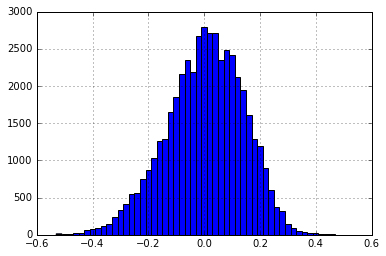

In [72]:
tmp_train_num.L3_S33_F3859.hist(bins=50)

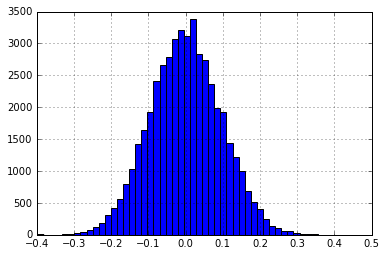

In [75]:
tmp_train_num.L3_S33_F3857.hist(bins=50)